<div align="center">
 <img src="https://raw.githubusercontent.com/matheusmota/dataviz2018/master/resources/images/logo_facens_pos.png" width="100x">
    <h3>Aplicações de Aprendizado de Máquina e Processamento de Linguagem Natural</h3>  
    <h1><center>Análise de Crédito (Give me some credit!)</center></h1>
</div>


* **203066**  - Evandro Bertolucci
* **110257**  - João Victor Carvalho
* **203071**  - Louise Constantino
* **203087**  - Luiza Constantino
* **203019**  - Murilo Piva
* **203263**  - Rafael Henrique

Neste exercício vamos construir um classificador para prever inadimplência de tomadores de empréstimo. O problema foi apresentado na plataforma Kaggle (https://www.kaggle.com/c/GiveMeSomeCredit), com o prêmio de 5000 USD para o ganhador. Os atributos disponíveis nos dados são descritos abaixo:

<img src="DescricaoAtributos.png">

Segundo as regras, a avaliação do modelo deve ser feita pela métrica AUC, sendo que melhor resultado obtido pelos participantes nos testes foi 0.8695:

<img src="Kaggle_Ranking.png">

Para facilitar, primeiro implementamos cada uma das etapas da Extração de Conhecimento em rotinas separadas, em seguida essas são chamadas abaixo no programa principal.

## 0. Importação de módulos

In [2]:
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')


## 1.1. Carga de dados

In [5]:
# Para este problema temos dois arquivos: treino e teste. O arquivo de teste, no entanto, não está rotulado, 
# logo trabalharemos apenas com os dados de treino
def carrega_treino():
    url = "https://raw.githubusercontent.com/brvnl/AplicacoesAprendizadoMaquina/main/cs-training.csv"
    df = pd.read_csv(url)
    df.drop(columns="Unnamed: 0", inplace=True)
    return df

## 1.2. Análise exploratória

In [6]:
# Para atributos numéricos discretos, esta função conta a quantidade de registros por valor,
# providenciando a distribuição para as duas classes.
def countplot_comparisson(df):
    int_attr = ["age", 
                "NumberOfDependents",
                "NumberOfOpenCreditLinesAndLoans", 
                "NumberRealEstateLoansOrLines", 
                "NumberOfTime30-59DaysPastDueNotWorse", 
                "NumberOfTime60-89DaysPastDueNotWorse",
                "NumberOfTimes90DaysLate"]
    
    for c in int_attr:
        fig2, ax2 = plt.subplots(figsize=(20,8))
        sns.countplot(x=c, hue="SeriousDlqin2yrs", data=df).set_title(c)
        
    return

# Para atributos numéricos contínuos esta função exibe a distribuição dos dados em formato 
# box-plot, um para cada classe.
def boxplot_comparisson(df):
    float_attr = ["MonthlyIncome", 
                  "RevolvingUtilizationOfUnsecuredLines", 
                  "DebtRatio"]
    
    for c in float_attr:
        fig3, ax3 = plt.subplots(figsize=(20,8))
        
        g = sns.boxplot(x="SeriousDlqin2yrs", hue="SeriousDlqin2yrs", y=c, data=df)
        g.set_title(c)
        g.set_yscale("log")
        
# Checa a correlação entre cada um dos atributos (são todos numéricos)
def check_correlation(df): 
    fig, ax = plt.subplots(figsize=(20,8))
    sns.heatmap(
        df.corr(), 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot = True
    ).set_title('Correlação')
    
    return 

# Exibe informações básicas sobre o dataset. Comente/ descomente as linhas 
# conforme quiser.
def analise_exploratoria(df):
    fig1, ax1 = plt.subplots(figsize=(20,8))
    sns.countplot(x="SeriousDlqin2yrs", data=df).set_title('Balanceamento de Classes')

    countplot_comparisson(df)
    boxplot_comparisson(df)
    check_correlation(df)
    
    return

## 1.3 Pré Processamento

In [7]:
# Ajusta a diferença de registros entre as classes
def reamostragem(X, Y):
    smt = SMOTETomek(sampling_strategy='all')
    X_smt, y_smt = smt.fit_resample(X, Y)

    previous_pos = len(Y[Y["SeriousDlqin2yrs"]==1])
    previous_neg = len(Y[Y["SeriousDlqin2yrs"]==0])
    current_pos = len(y_smt[y_smt==1])
    current_neg = len(y_smt[y_smt==0])
    
    print("INFO* Antes da reamostragem: Pos=%d/ Neg=%d; Após reamostragem: Pos=%d/ Neg=%d." %(previous_pos, previous_neg, current_pos, current_neg))
    
    return (X_smt, y_smt)

# Normaliza os valores numéricos pela média e desvio padrão.
def normalizacao_mean_std(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X


# Esta função deve realizar todas as etapas de pre-processamento antes de calibrar o modelo.
def preprocessamento(df):  

    #Preenche MonthlyIncome com a moda
    df['MonthlyIncome'].fillna(df['MonthlyIncome'].mode()[0], inplace=True)

    #Preenche NumberOfDependents com zero (Entende-se que quando não informado é zero)
    df['NumberOfDependents'].fillna(0, inplace=True)   
    
    
    # Separando 
    Y = df["SeriousDlqin2yrs"].to_frame()
    X = df.drop(columns="SeriousDlqin2yrs")
    
    # Normalizar atributos independentes
    #X = normalizacao_mean_std(X)

    return (X, Y)

## 2. Amostragem e treino

## 2.1 - KNN com GridSearch - Com e Sem Reamostragem

In [8]:
# Esta função deve reunir todas as etapas para a obtenção do modelo, seja diretamente
# sobre os dados de treino (Hold Out) ou por otimização Validação Cruzada + Grid Search.
# Escolha o método de classificação de sua preferência.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import scipy.stats

def otimizacao_rs(X_train_rs, Y_train_rs):
    
    start_time = time.time()
    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_rs, y_train_rs)

    scores = cross_val_score(knn, X, Y, cv=5) # 5 execuções diferentes com 20% dos dados para teste

    print('Acurácia - %.2f +- %.2f' % (scores.mean() * 100, scores.std() * 100))    

    grid_params = {
        'n_neighbors': [3, 5, 11, 20],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        #'algorithm': ['ball_tree', 'kd_tree']
        #'leaf_size' : [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    }


    gs = GridSearchCV(knn, grid_params, cv=5, n_jobs=1)

    gs_results = gs.fit(X_train_rs, y_train_rs)
    
    model = gs_results

    process = '%s"' % round((time.time() - start_time),5)
    
    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    print("Tempo de Processamento: ", process)

    
    return model


def otimizacao(X_train, Y_train):

    start_time = time.time()
    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)

    scores = cross_val_score(knn, X, Y, cv=5) # 5 execuções diferentes com 20% dos dados para teste

    print('Acurácia - %.2f +- %.2f' % (scores.mean() * 100, scores.std() * 100))    

    grid_params = {
        'n_neighbors': [3, 5, 11, 20],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        #'algorithm': ['ball_tree', 'kd_tree']
        #'leaf_size' : [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    }

    gs = GridSearchCV(knn, grid_params, cv=5, n_jobs=1)

    gs_results = gs.fit(X_train, y_train)
    
    model = gs_results
    
    process = '%s"' % round((time.time() - start_time),5)

    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    print("Tempo de Processamento: ", process)
    
    return model


## 2.2 - XGBoost com escalonamento e sem escalonamento de pesos

In [10]:
import xgboost as xgb

def otimizacao_xgb(X_train, Y_train):
    
    start_time = time.time()
    model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    model.fit(X_train,y_train)
    process = '%s"' % round((time.time() - start_time),5)
    
    print('Score:', model.score(X_test,y_test))
    print("Tempo de Processamento: ", process)
    
    return model

def otimizacao_xgb_w(X_train, Y_train):
    
    weight = int(y_train.count()/y_train.sum())

    start_time = time.time()
    model = xgb.XGBClassifier(objective="binary:logistic", random_state=42,scale_pos_weight = weight)    
    model.fit(X_train,y_train)
   
    process = '%s"' % round((time.time() - start_time),5)
    
    print('Score:', model.score(X_test,y_test))
    print("Tempo de Processamento: ", process)
    
    return model


## 2.3 - Random Forest com GridSearch

In [11]:
from sklearn.ensemble import RandomForestClassifier

def otimizacao_rf(X_train, Y_train):

    start_time = time.time()
    grid_params = {
        'criterion': ['gini','entropy'],
        'max_depth': [80, 90, 100, 110],
        'max_features': [2, 3],
        'n_estimators': [50, 70, 100]        
   }

    dtc = RandomForestClassifier()
    
    gs = GridSearchCV(dtc, grid_params, cv=5, n_jobs=1)

    gs_results = gs.fit(X_train, y_train)
    
    process = '%s"' % round((time.time() - start_time),5)
    
    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    print("Tempo de Processamento: ", process)
    
    return model

def otimizacao_rf_best(X_train, Y_train):

    start_time = time.time()
    grid_params = {
        'criterion': ['entropy'],
        'max_depth': [80],
        'max_features': [2],
        'n_estimators': [100]
   }

    dtc = RandomForestClassifier()
    
    gs = GridSearchCV(dtc, grid_params, cv=5, n_jobs=1)

    gs_results = gs.fit(X_train, y_train)
    
    process = '%s"' % round((time.time() - start_time),5)
    
    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    print("Tempo de Processamento: ", process)
    
    return model


## 3. Resultados

In [12]:
# Essa função exibe os resultados da classificação pelo modelo gerado. Para tanto, a função
# espera receber um dicionário cuja primeira chave é a fase (Treino, Validação e Teste) e a 
# segunda os dados (actual, pred e pred_prob).
def resultados(res):

    # Medidas de acerto 
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        print(classification_report(res[phase]["actual"], res[phase]["pred"]))
    
    # Matriz de Confusão
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        skplt.metrics.plot_confusion_matrix(res[phase]["actual"], res[phase]["pred"])
        plt.show()
    
    # Curva ROC-AUC
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        skplt.metrics.plot_roc_curve(res[phase]["actual"], res[phase]["prob"])
        plt.show()
    
    prob_tst = model.predict_proba(X_test)
    prob_1 = prob_tst[:,1]
    
    prob_tr = model.predict_proba(X_train)
    prob_2 = prob_tr[:,1]
    
    print('AUC Score Train: ', (roc_auc_score(y_train,prob_2)))
    print('AUC Score Test: ', (roc_auc_score(y_test,prob_1)))


    return

# Programa Principal

Carregando os dados:

In [13]:
# Carrega os dados para um daframe
df_treino = carrega_treino()
print("INFO* Registros de treino orginais: %d; Colunas: %d." %(df_treino.shape))

INFO* Registros de treino orginais: 150000; Colunas: 11.


Análise exploratória (opcional):

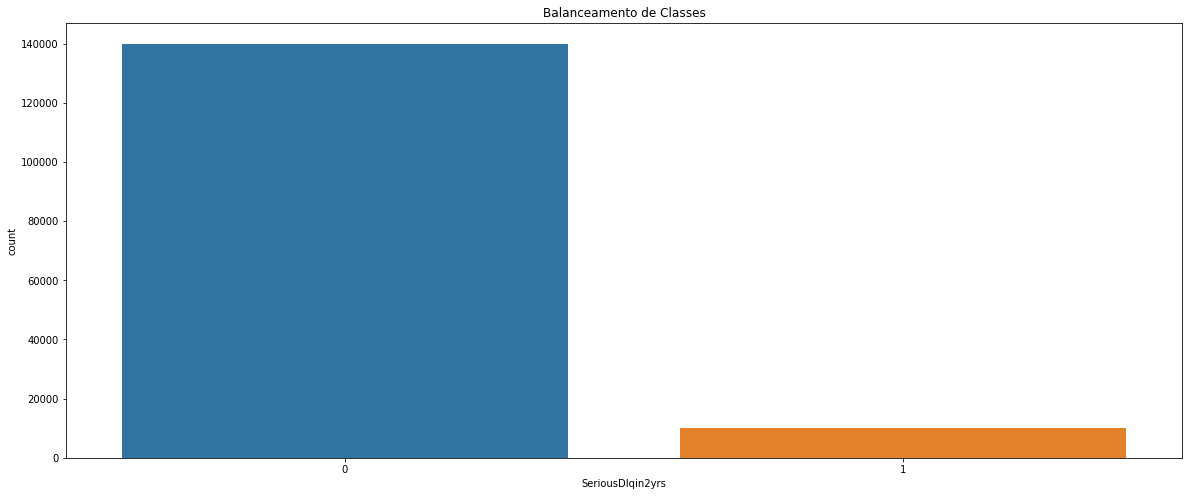

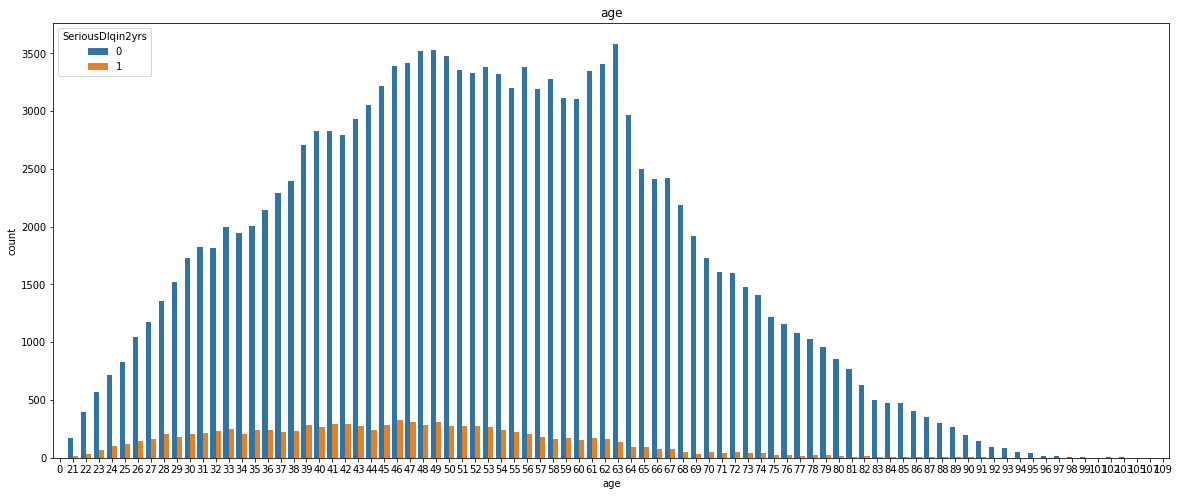

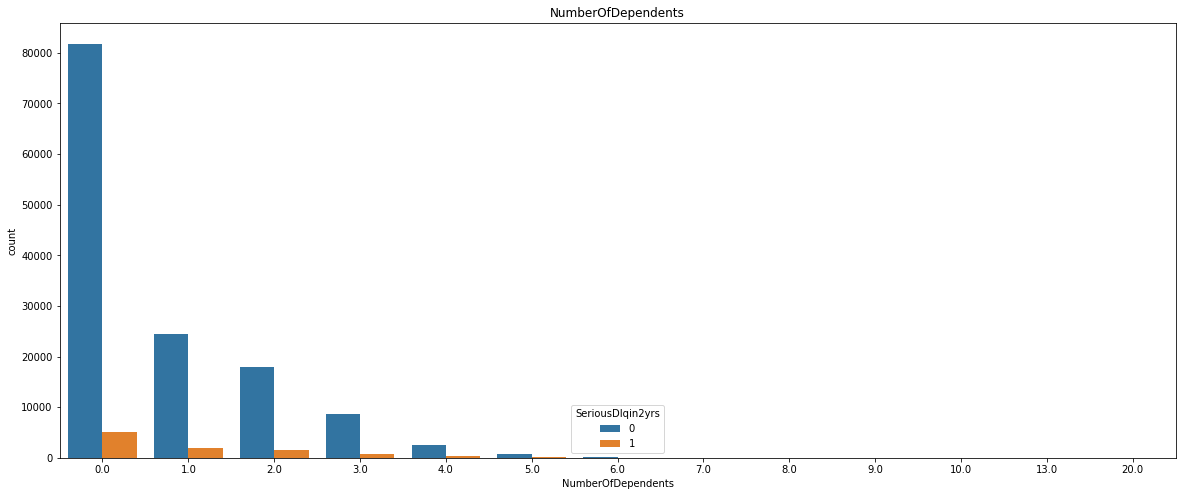

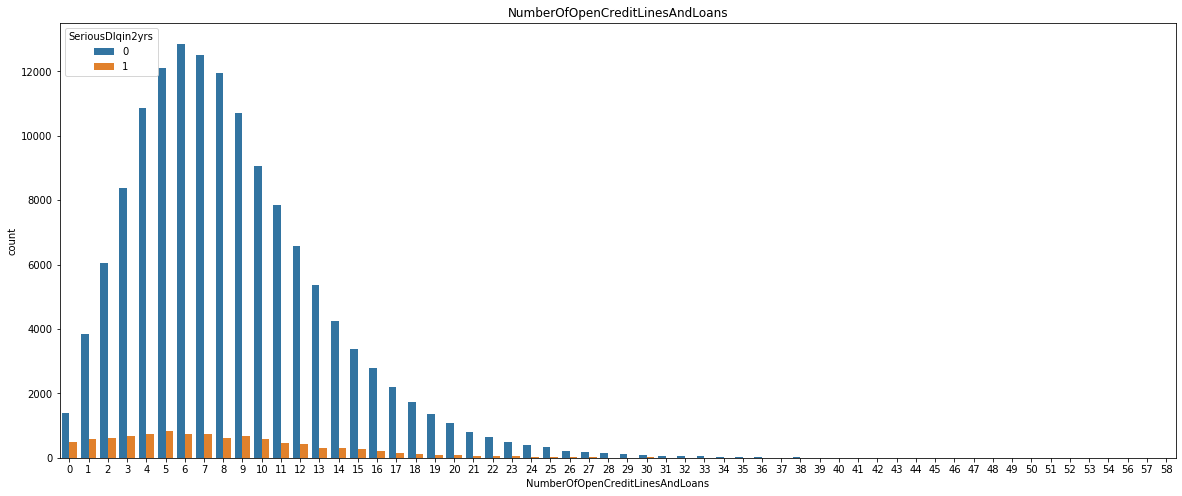

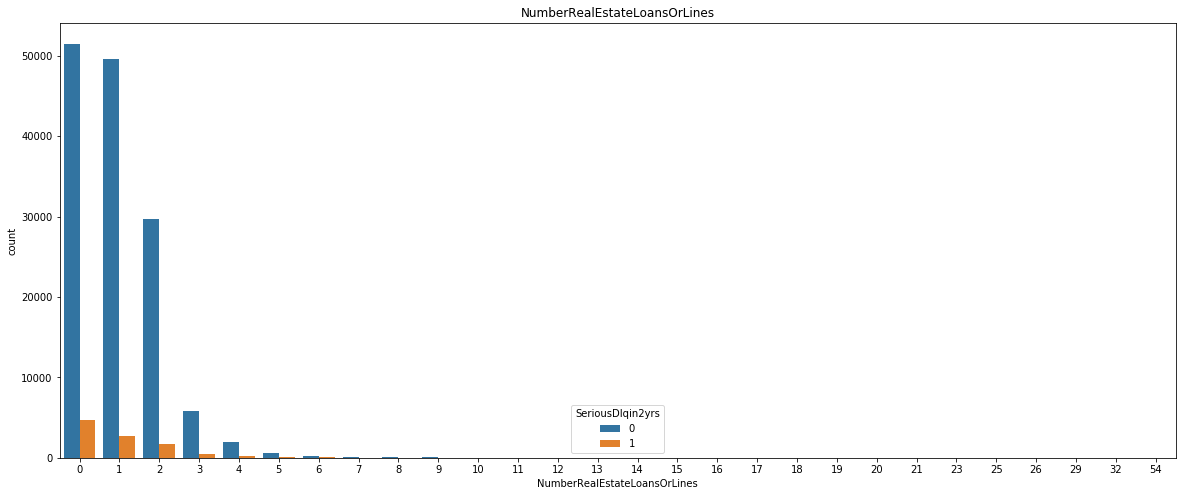

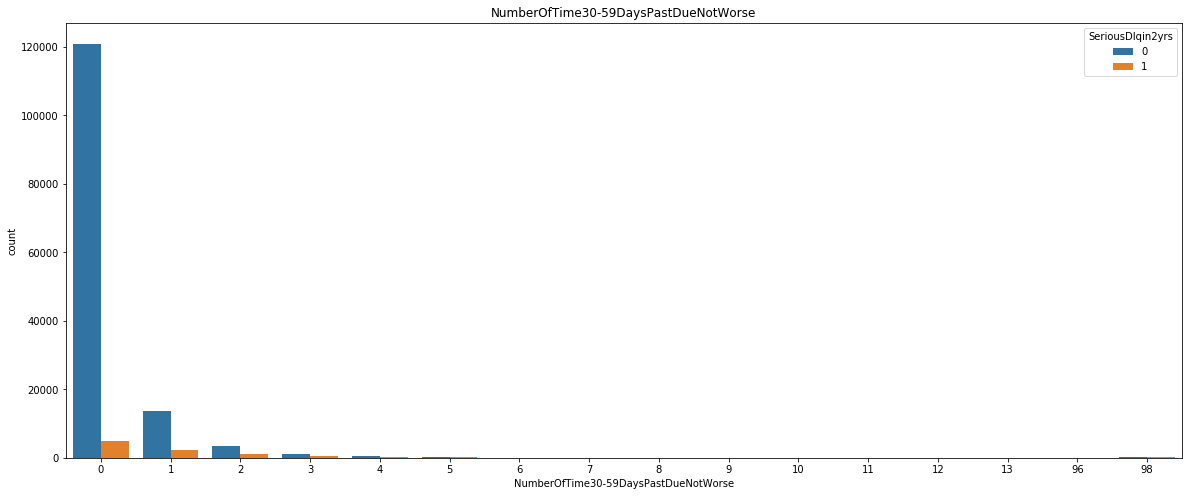

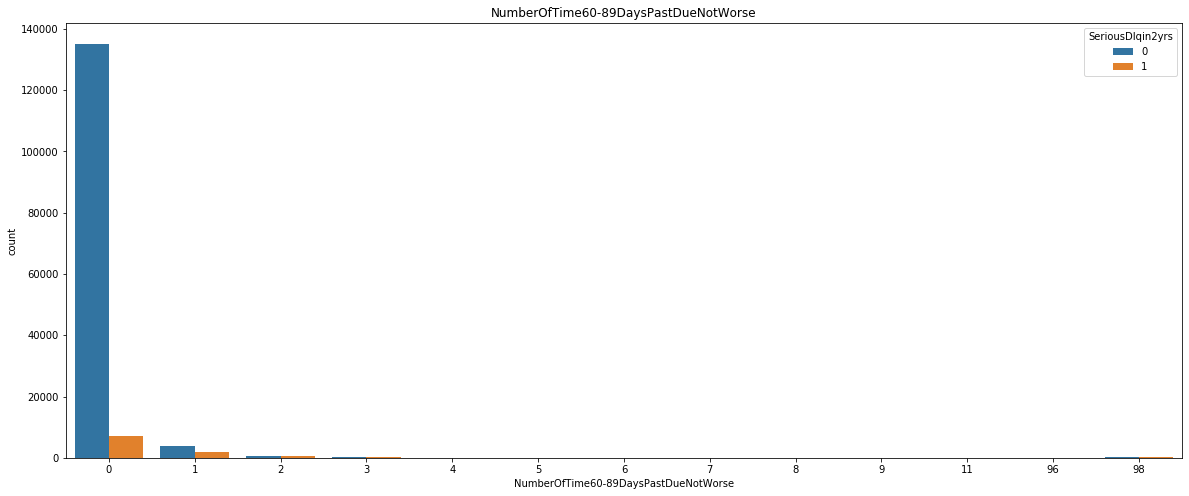

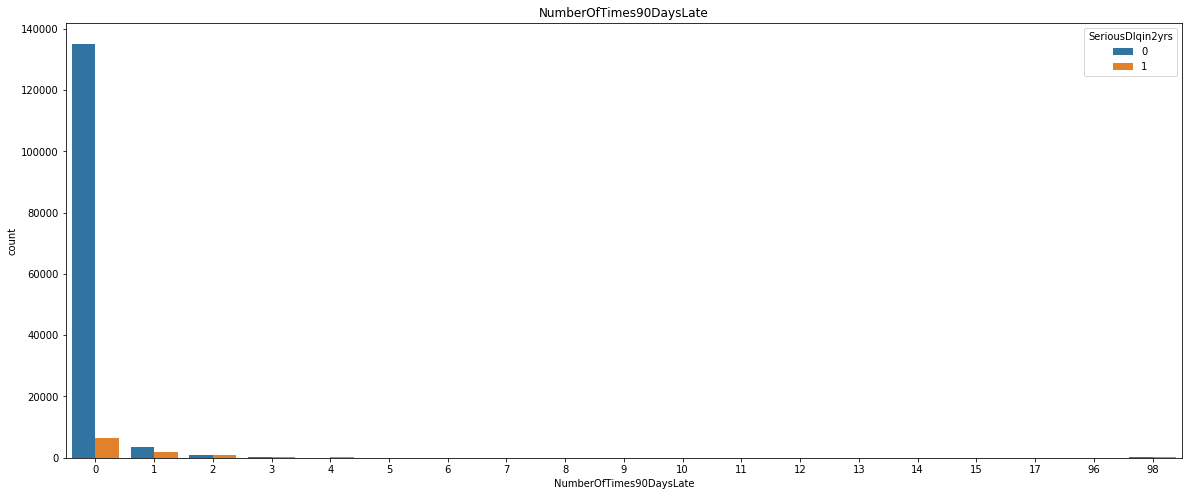

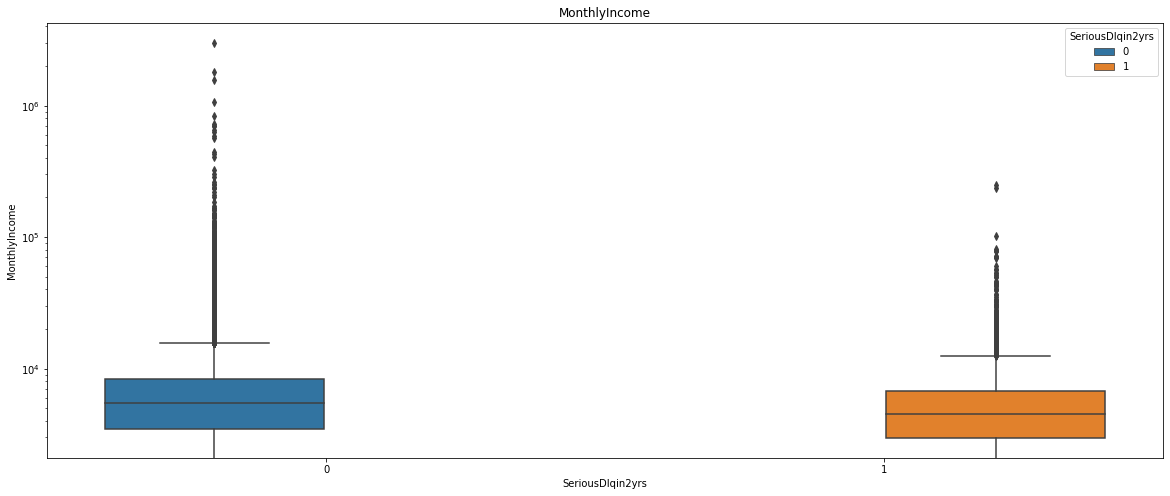

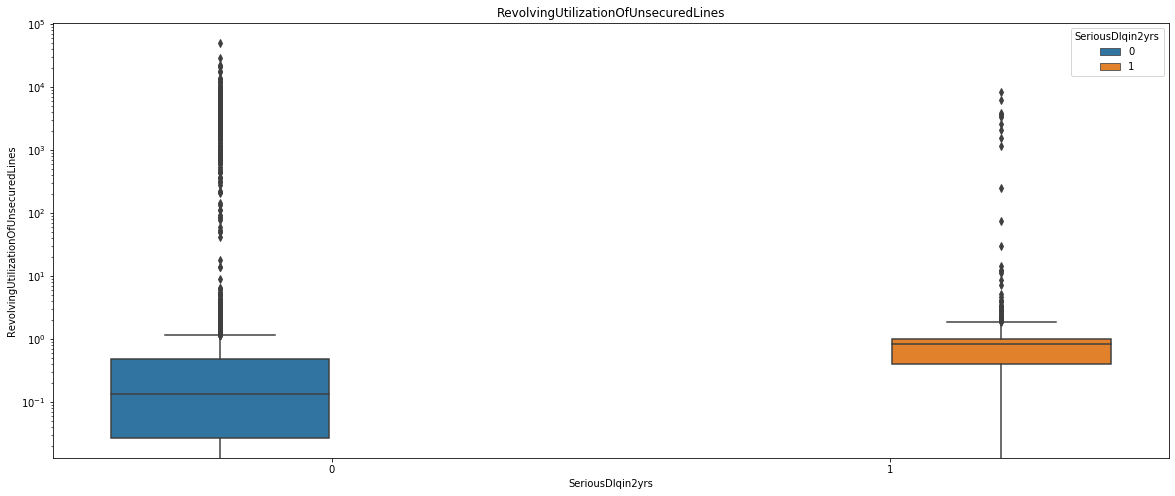

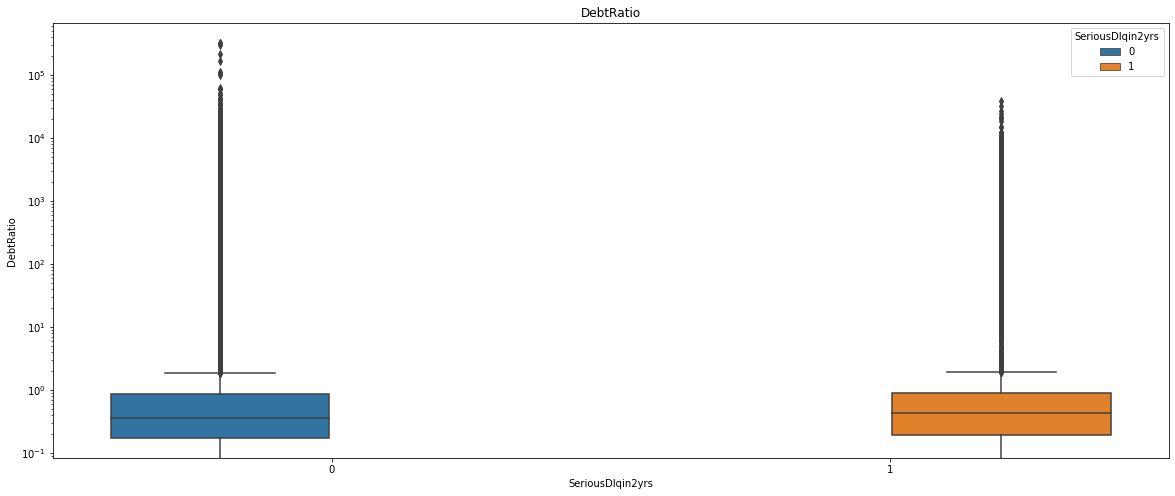

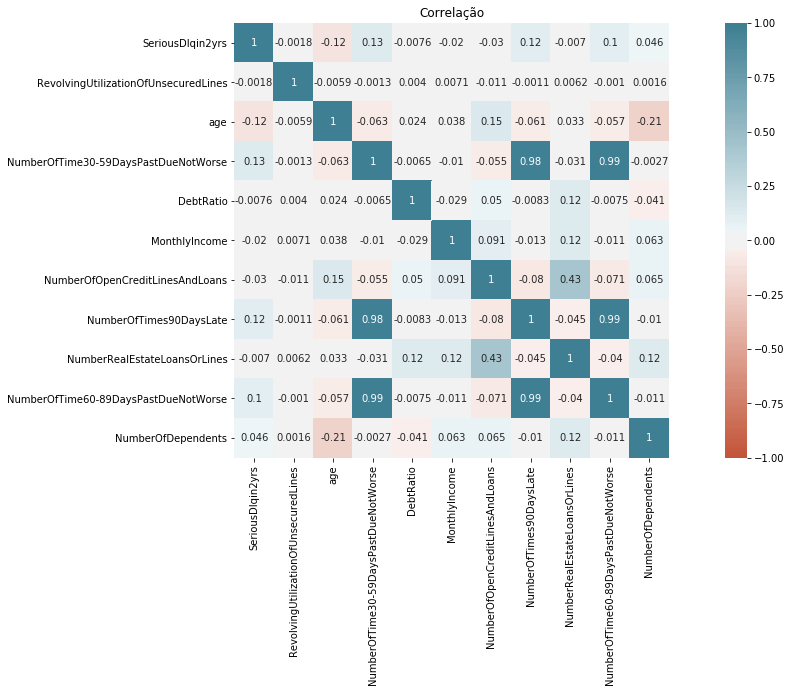

In [14]:
# Exibe características do atributo alvo, dos demais atributos e da relação entre eles.
analise_exploratoria(df_treino)

In [15]:
#Verificando se há registros nulos
df_treino.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Pré-processamento e separação Treino/Teste:

In [16]:
# Executa todas as rotinas de preprocessamento e separa atributo alvo
X, Y = preprocessamento(df_treino)
print("INFO* Registros após preproc: %d; Colunas em X: %d; Colunas em Y: 1." %(X.shape))

# Separa 5% dos dados para teste (+- 5000 registros)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, stratify=Y, shuffle=True)
print("INFO* Registros separados para treino: %d; teste: %d." %(len(y_train), len(y_test)))

INFO* Registros após preproc: 150000; Colunas em X: 10; Colunas em Y: 1.
INFO* Registros separados para treino: 142500; teste: 7500.


Ajuste de balanceamento (opcional):

In [17]:
# Emprega tecnicas de reamostragem para tratar o desbalanceamento de classes
X_train_rs, y_train_rs = reamostragem(X_train, y_train)
print("INFO* Registros de treino após reamostragem: %d linhas, %d colunas." %(X_train_rs.shape))

INFO* Antes da reamostragem: Pos=9525/ Neg=132975; Após reamostragem: Pos=260518/ Neg=260518.
INFO* Registros de treino após reamostragem: 260518 linhas, 10 colunas.


# Resultado 2.1 - KNN Sem Reamostragem

In [18]:
# Treinamento com dados sem reamostragem
model = otimizacao(X_train, y_train)

Acurácia - 92.75 +- 0.08
0.9334807017543859
KNeighborsClassifier(metric='euclidean', n_neighbors=20)
{'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}
Tempo de Processamento:  547.60777"


-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       0.93      1.00      0.97    132975
           1       0.73      0.01      0.02      9525

    accuracy                           0.93    142500
   macro avg       0.83      0.50      0.49    142500
weighted avg       0.92      0.93      0.90    142500

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      6999
           1       0.75      0.01      0.02       501

    accuracy                           0.93      7500
   macro avg       0.84      0.51      0.49      7500
weighted avg       0.92      0.93      0.90      7500

-------------------------------------------------------------
Evaluating train


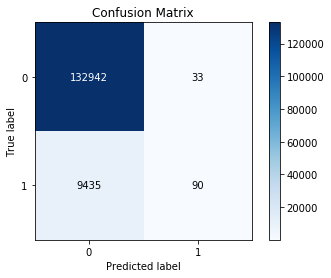

-------------------------------------------------------------
Evaluating test


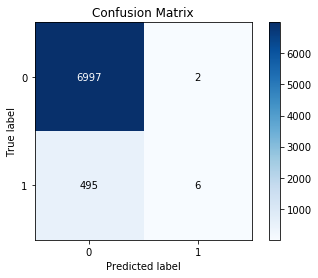

-------------------------------------------------------------
Evaluating train


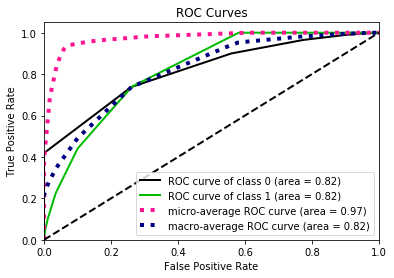

-------------------------------------------------------------
Evaluating test


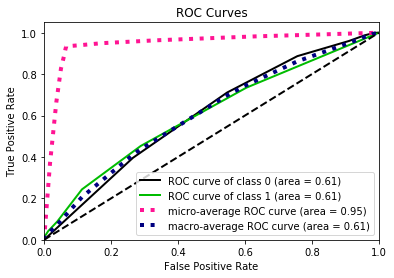

AUC Score Train:  0.8181985041491923
AUC Score Test:  0.6061426225987802


In [19]:
# Preenchendo performance em treino e teste
res = {"train": {"actual": y_train,
               "pred": model.predict(X_train),
               "prob": model.predict_proba(X_train)},
     
       "test": {"actual": y_test,
               "pred": model.predict(X_test),
               "prob": model.predict_proba(X_test)}}

# Exibindo resultados
resultados(res)

# Resultado 2.1 - KNN Com Reamostragem

In [20]:
# Treinamento com dados com reamostragem
model = otimizacao_rs(X_train_rs, y_train_rs)

Acurácia - 92.75 +- 0.08
0.8978995659658995
KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Tempo de Processamento:  1548.67404"


-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    132975
           1       0.87      1.00      0.93      9525

    accuracy                           0.99    142500
   macro avg       0.93      0.99      0.96    142500
weighted avg       0.99      0.99      0.99    142500

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      6999
           1       0.12      0.33      0.17       501

    accuracy                           0.79      7500
   macro avg       0.53      0.58      0.53      7500
weighted avg       0.89      0.79      0.83      7500

-------------------------------------------------------------
Evaluating train


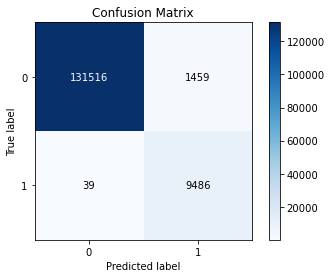

-------------------------------------------------------------
Evaluating test


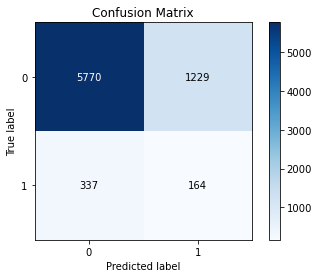

-------------------------------------------------------------
Evaluating train


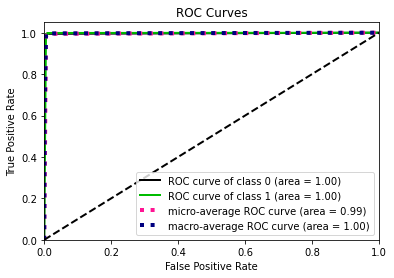

-------------------------------------------------------------
Evaluating test


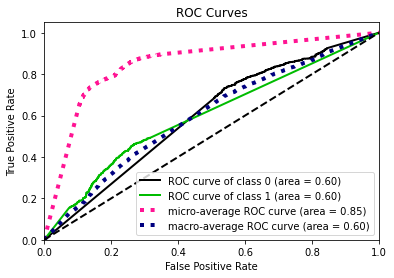

AUC Score Train:  0.9966523310925672
AUC Score Test:  0.5986335658444506


In [19]:
# Preenchendo performance em treino e teste
res = {"train": {"actual": y_train,
               "pred": model.predict(X_train),
               "prob": model.predict_proba(X_train)},
     
       "test": {"actual": y_test,
               "pred": model.predict(X_test),
               "prob": model.predict_proba(X_test)}}

# Exibindo resultados
resultados(res)

# Resultado 2.2 - XGBoost Sem Escalonamento

In [20]:
model = otimizacao_xgb(X_train, y_train)

[19:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score: 0.9321333333333334
Tempo de Processamento:  4.44369"


-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    132975
           1       0.78      0.29      0.43      9525

    accuracy                           0.95    142500
   macro avg       0.87      0.64      0.70    142500
weighted avg       0.94      0.95      0.94    142500

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      6999
           1       0.48      0.18      0.27       501

    accuracy                           0.93      7500
   macro avg       0.71      0.58      0.61      7500
weighted avg       0.91      0.93      0.92      7500

-------------------------------------------------------------
Evaluating train


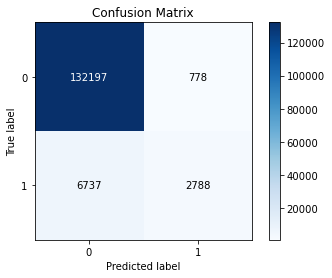

-------------------------------------------------------------
Evaluating test


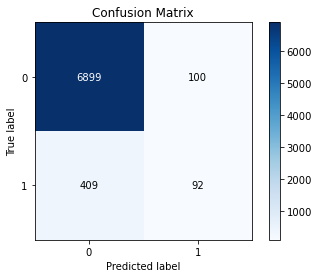

-------------------------------------------------------------
Evaluating train


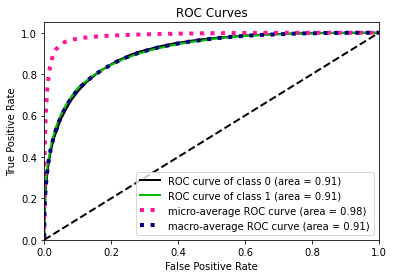

-------------------------------------------------------------
Evaluating test


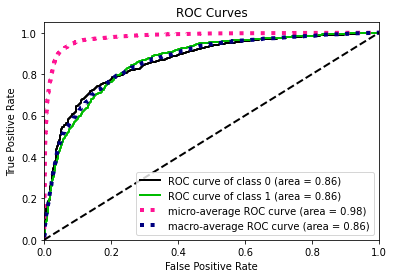

AUC Score Train:  0.9080883788567601
AUC Score Test:  0.8643515939973175


In [21]:
# Preenchendo performance em treino e teste
res = {"train": {"actual": y_train,
               "pred": model.predict(X_train),
               "prob": model.predict_proba(X_train)},
     
       "test": {"actual": y_test,
               "pred": model.predict(X_test),
               "prob": model.predict_proba(X_test)}}

# Exibindo resultados
resultados(res)

# Resultado 2.2 - XGBoost Com Escalonamento

In [22]:
model = otimizacao_xgb_w(X_train, y_train)

[19:01:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score: 0.8230666666666666
Tempo de Processamento:  4.0292"


-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       0.99      0.84      0.91    132975
           1       0.27      0.84      0.41      9525

    accuracy                           0.84    142500
   macro avg       0.63      0.84      0.66    142500
weighted avg       0.94      0.84      0.87    142500

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      6999
           1       0.23      0.72      0.35       501

    accuracy                           0.82      7500
   macro avg       0.61      0.78      0.63      7500
weighted avg       0.93      0.82      0.86      7500

-------------------------------------------------------------
Evaluating train


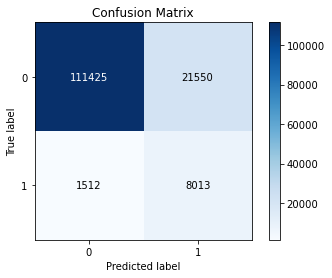

-------------------------------------------------------------
Evaluating test


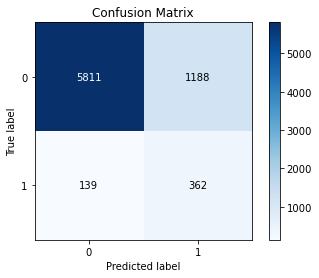

-------------------------------------------------------------
Evaluating train


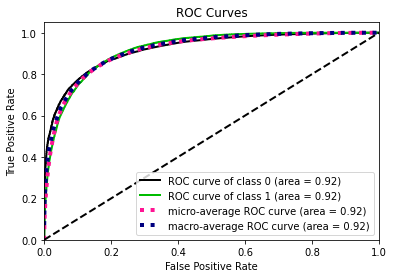

-------------------------------------------------------------
Evaluating test


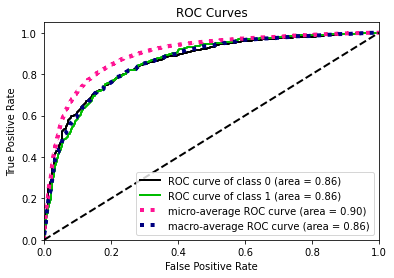

AUC Score Train:  0.920780755366662
AUC Score Test:  0.8609832770521253


In [23]:
# Preenchendo performance em treino e teste
res = {"train": {"actual": y_train,
               "pred": model.predict(X_train),
               "prob": model.predict_proba(X_train)},
     
       "test": {"actual": y_test,
               "pred": model.predict(X_test),
               "prob": model.predict_proba(X_test)}}

# Exibindo resultados
resultados(res)

# Resultado 2.3 - Random Forest 

In [24]:
# -- Comentado devido ao alto tempo de processamento
#model = otimizacao_rf(X_train, y_train)

In [25]:
model = otimizacao_rf_best(X_train, y_train)

0.9360701754385964
RandomForestClassifier(criterion='entropy', max_depth=80, max_features=2)
{'criterion': 'entropy', 'max_depth': 80, 'max_features': 2, 'n_estimators': 100}
Tempo de Processamento:  95.60505"


-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       0.99      0.84      0.91    132975
           1       0.27      0.84      0.41      9525

    accuracy                           0.84    142500
   macro avg       0.63      0.84      0.66    142500
weighted avg       0.94      0.84      0.87    142500

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.98      0.83      0.90      6999
           1       0.23      0.72      0.35       501

    accuracy                           0.82      7500
   macro avg       0.61      0.78      0.63      7500
weighted avg       0.93      0.82      0.86      7500

-------------------------------------------------------------
Evaluating train


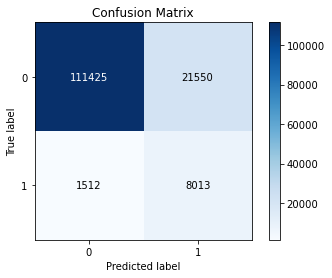

-------------------------------------------------------------
Evaluating test


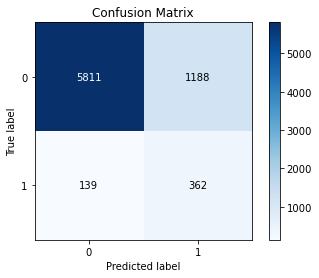

-------------------------------------------------------------
Evaluating train


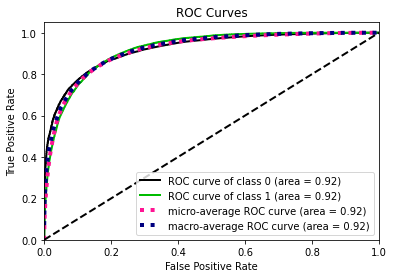

-------------------------------------------------------------
Evaluating test


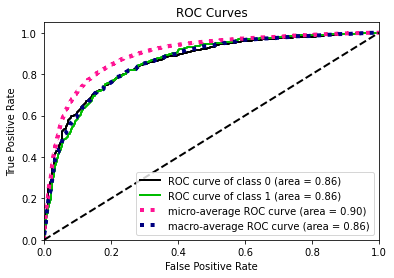

AUC Score Train:  0.920780755366662
AUC Score Test:  0.8609832770521253


In [26]:
# Preenchendo performance em treino e teste
res = {"train": {"actual": y_train,
               "pred": model.predict(X_train),
               "prob": model.predict_proba(X_train)},
     
       "test": {"actual": y_test,
               "pred": model.predict(X_test),
               "prob": model.predict_proba(X_test)}}

# Exibindo resultados
resultados(res)

# Conclusão

- **KNN com GridSearch (Com e Sem Reamostragem)** = apresentou ótima acurácia, porém o tempo de processamento foi significativamente superior aos demais. Além disso, a AUC apresentou baixo desempenho nos dados de teste, portanto foi desconsiderado.


- **XGBoost com escalonamento** = foi o modelo que apresentou a menor acurácia, consequentemente também foi desconsiderado.


- **XGBoost sem escalonamento** = considerado o melhor modelo, pois apresentou a melhor acurácia, assim como o melhor desempenho na AUC, mantendo também o tempo de processamento muito baixo. Considerando a avaliação de análise de crédito, os resultados de Recall e Presision são satisfatórios.


- **Random Forest com GridSearch** = apresentou ótima acurácia e bom desempenho na AUC, porém o tempo de processamento foi muito alto, o que não compensa ao comparar com os resultados do XGBoost.


<div>
  <h4>Avaliando as métricas de avaliação e tempo de processamento entre os modelos testados, conclui-se que o melhor resultado foi obtido utilizando o método XGBoost sem escalonamento de pesos</h4>  
</div>

* Tratamentos no dataset:
    - Registros nulos da coluna MonthlyIncome foram preenchidos com a moda dos valores    
    - Registros nulos da coluna NumberOfDependents foram preenchidos com zero
    

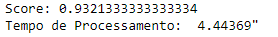
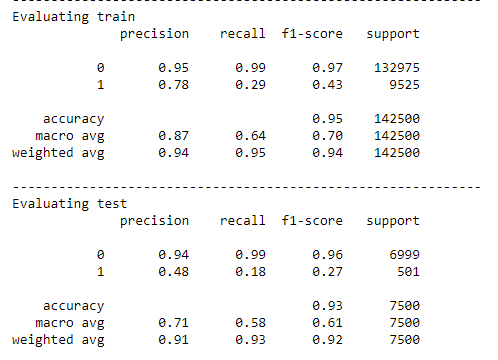
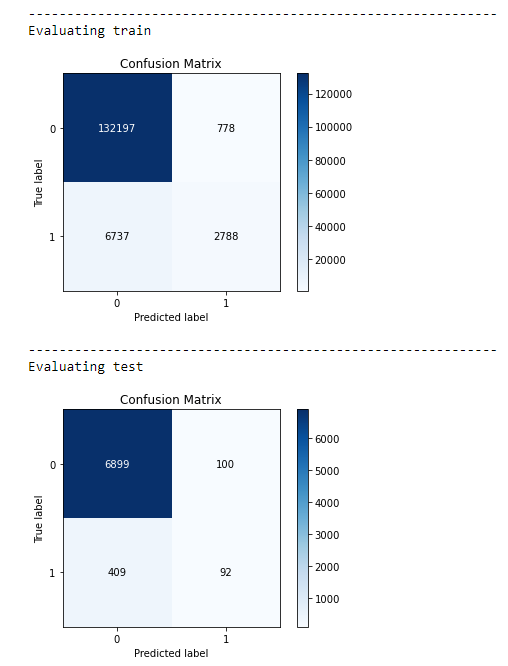 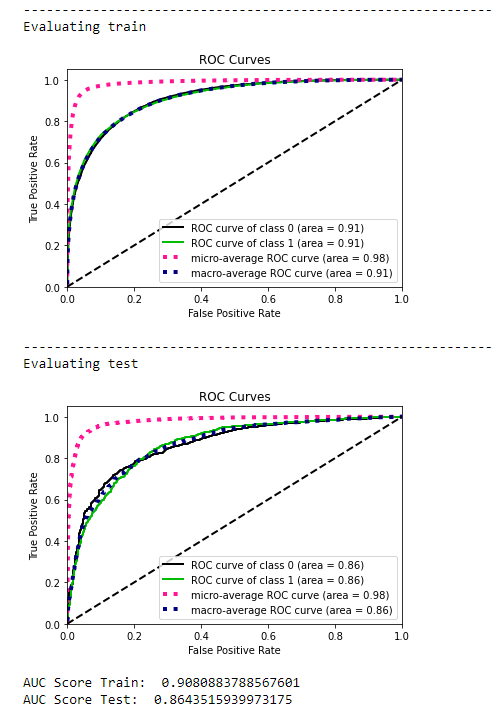